# Anomaly Detection using vision transformer based Autoencoder

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### NEW

In [56]:
import torch
import torch.nn as nn
from timm import create_model
import torch.nn.functional as F

class ViTEncoderDecoder(nn.Module):
    def __init__(self, vit_model_name='vit_base_patch16_224', image_size=224):
        super(ViTEncoderDecoder, self).__init__()

        # ----------------------
        # Encoder (Pretrained ViT)
        # ----------------------
        self.encoder = create_model(vit_model_name, pretrained=True)
        self.encoder.reset_classifier(0)  # remove classifier

        # ----------------------
        # Decoder (Weaker)
        # ----------------------
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(768, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14→28
            nn.InstanceNorm2d(256), nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28→56
            nn.InstanceNorm2d(128), nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # 56→112
            nn.InstanceNorm2d(64), nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),     # 112→224
            nn.Sigmoid()
        )

        self.image_size = image_size

        # ----------------------
        # Freeze most encoder layers
        # ----------------------
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.encoder.blocks[-1].parameters():  # fine-tune only last block
            param.requires_grad = True

    def forward(self, x):
        # Encode
        encoded = self.encoder.forward_features(x)  # (B, N, D)
        encoded = encoded[:, 1:, :]  # remove class token

        B, N, D = encoded.shape
        h = w = int(N ** 0.5)
        encoded = encoded.permute(0, 2, 1).reshape(B, D, h, w)

        # Decode
        reconstructed = self.decoder(encoded)

        # Upsample to match input (in case sizes mismatch)
        reconstructed = F.interpolate(
            reconstructed, size=(x.size(2), x.size(3)),
            mode='bilinear', align_corners=False
        )
        return reconstructed


In [58]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Path to your dataset folder containing only "good" images
dataset_dir = '/content/drive/MyDrive/ML/Datasets/mvtec_ad'

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create dataset and loader
train_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

print(f"Loaded {len(train_dataset)} normal images for training.")


Loaded 235 normal images for training.


In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ViTEncoderDecoder(image_size=224).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch, _ in train_loader:  # train_loader must be defined
        batch = batch.to(device)

        reconstructed = model(batch)
        loss = criterion(reconstructed, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.6f}")

print("✅ Training complete!")


Epoch [1/20] - Loss: 0.063900
Epoch [2/20] - Loss: 0.022156
Epoch [3/20] - Loss: 0.013456
Epoch [4/20] - Loss: 0.009188
Epoch [5/20] - Loss: 0.006916
Epoch [6/20] - Loss: 0.005530
Epoch [7/20] - Loss: 0.004522
Epoch [8/20] - Loss: 0.003909
Epoch [9/20] - Loss: 0.003355
Epoch [10/20] - Loss: 0.002931
Epoch [11/20] - Loss: 0.002621
Epoch [12/20] - Loss: 0.002368
Epoch [13/20] - Loss: 0.002186
Epoch [14/20] - Loss: 0.002018
Epoch [15/20] - Loss: 0.001880
Epoch [16/20] - Loss: 0.001761
Epoch [17/20] - Loss: 0.001652
Epoch [18/20] - Loss: 0.001560
Epoch [19/20] - Loss: 0.001469
Epoch [20/20] - Loss: 0.001387
✅ Training complete!


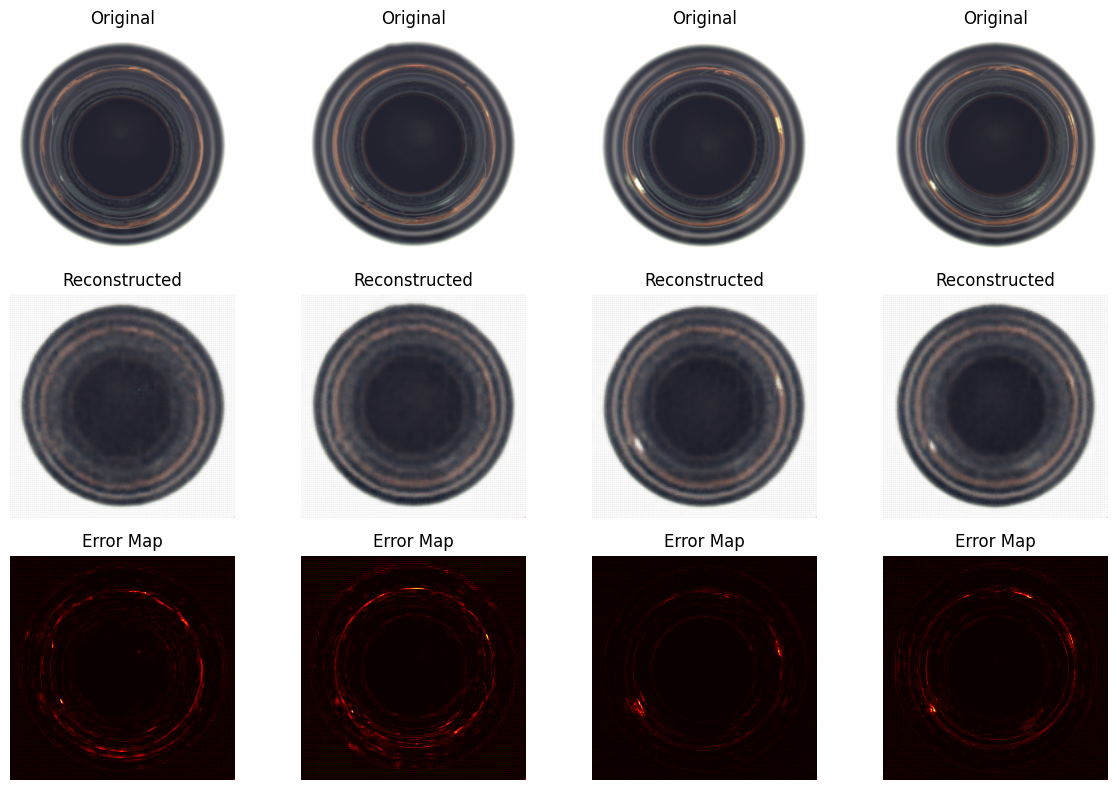

In [63]:
model.eval()
sample, _ = next(iter(train_loader))
sample = sample.to(device)

with torch.no_grad():
    reconstructed = model(sample)

# Move to CPU for plotting
sample = sample.cpu()
reconstructed = reconstructed.cpu()

# Compute per-pixel error (MSE over channels)
error_map = torch.mean((sample - reconstructed) ** 2, dim=1)  # shape: [B, H, W]

import matplotlib.pyplot as plt

# Create a 3-row subplot: Original / Reconstructed / Error Map
fig, axes = plt.subplots(3, len(sample), figsize=(12, 8))

for i in range(len(sample)):
    # Original
    axes[0, i].imshow(sample[i].permute(1, 2, 0))
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    # Reconstructed
    axes[1, i].imshow(reconstructed[i].permute(1, 2, 0))
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

    # Error Map
    axes[2, i].imshow(error_map[i], cmap='hot')
    axes[2, i].set_title("Error Map")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()


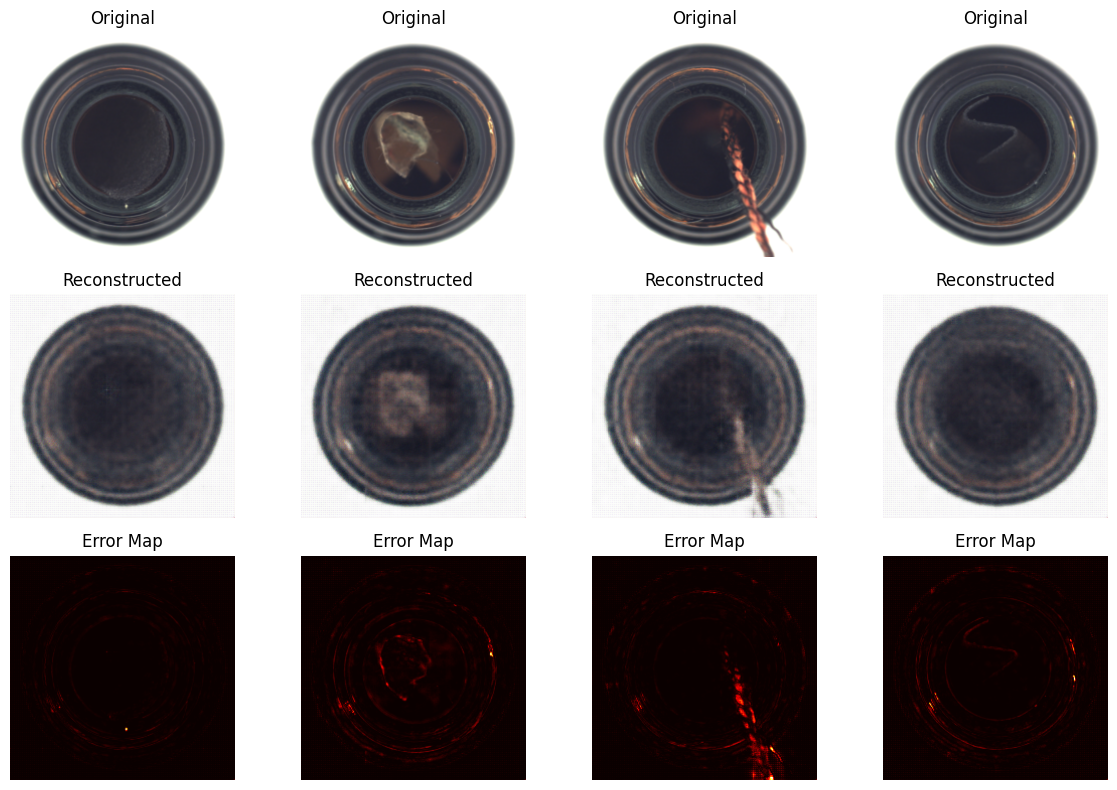

In [62]:
from PIL import Image
from glob import glob
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# ------------------------------
# Paths & Transforms
# ------------------------------
defect_dir = '/content/drive/MyDrive/ML/Datasets/mvtec_ad/contamination'
defect_paths = glob(defect_dir + '/*.png')

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # must match training
    transforms.ToTensor()
])

# ------------------------------
# Pick a few defective images
# ------------------------------
num_samples = 4  # number of images to visualize
samples = defect_paths[:num_samples]

# Load and stack as batch
images = []
for path in samples:
    img = Image.open(path).convert("RGB")
    images.append(transform(img))

batch = torch.stack(images).to(device)  # shape: [B,3,H,W]

# ------------------------------
# Reconstruct
# ------------------------------
model.eval()
with torch.no_grad():
    reconstructed = model(batch)

# Move to CPU for plotting
batch = batch.cpu()
reconstructed = reconstructed.cpu()

# ------------------------------
# Compute Error Map (per-pixel MSE)
# ------------------------------
error_map = torch.mean((batch - reconstructed)**2, dim=1)  # shape: [B,H,W]

# ------------------------------
# Plot Original / Reconstructed / Error Map
# ------------------------------
fig, axes = plt.subplots(3, len(batch), figsize=(12, 8))
for i in range(len(batch)):
    axes[0, i].imshow(batch[i].permute(1,2,0))
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    axes[1, i].imshow(reconstructed[i].permute(1,2,0))
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

    axes[2, i].imshow(error_map[i], cmap='hot')
    axes[2, i].set_title("Error Map")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()
